# Comparison of Neural network, LSTM and HNN based integrator

In [ ]:
import sys
sys.path.append('..')

import numpy as np
from matplotlib import pyplot as plt
from Code.dynamical_system import *
from Code.time_integrator import *
from Code.neuralnet import *

np.random.seed(2512517)

##Initalise network and verlet integrator parameters

Set system parameters, construct dynamical system and integrator.

The timestep size of the Neural network integrator is set to $\Delta t=40\Delta t_{\text{Verlet}}$ where $\Delta t_{\text{Verlet}}$ is the step size of the Verlet integrator that is used for training.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 4)]       0           []                               
                                                                                                  
 flatten (Flatten)              (None, 16)           0           ['input_1[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 64)           1088        ['flatten[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 64)           4160        ['dense_4[0][0]']                
                                                                                              

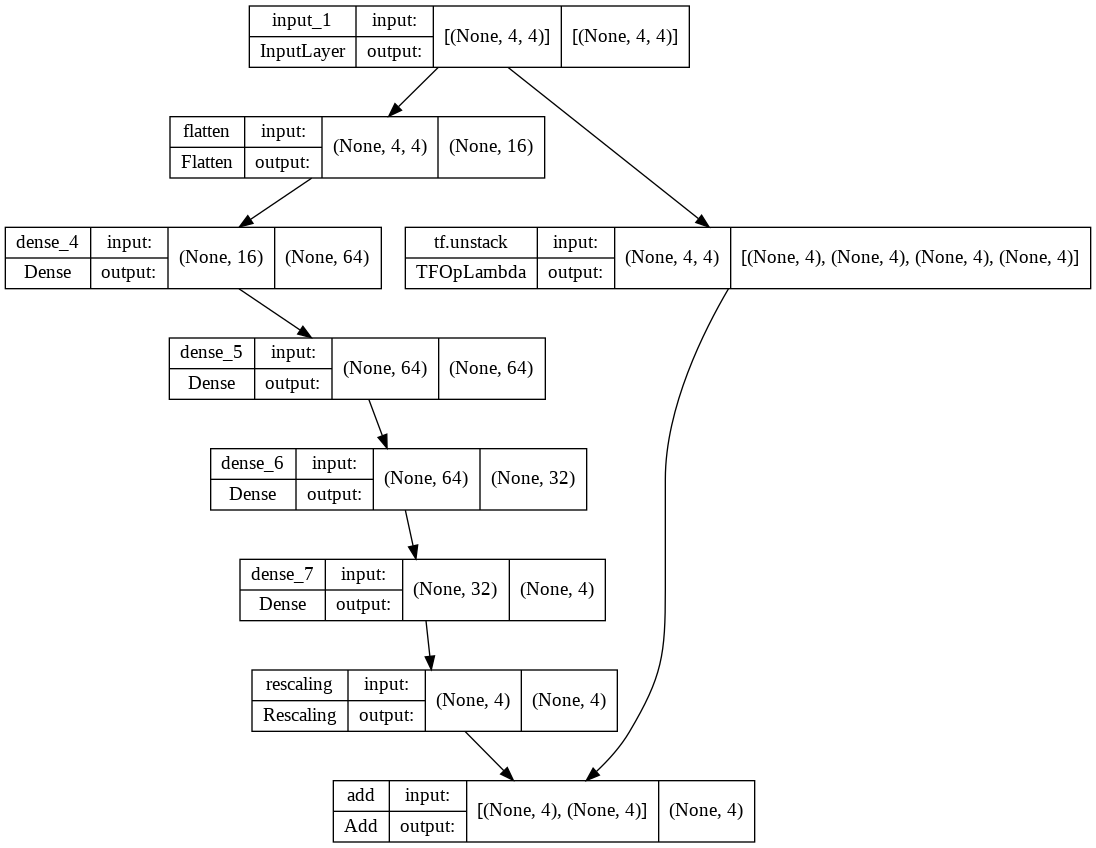

In [ ]:
# mass of particle
mass = 1
# timestep for Verlet integrator
dt_verlet = 0.001
# timestep for neural network integrators
dt = 40*dt_verlet

# number of steps for neural network integrator
nsteps_1 = 4
#number of steps for the LSTM integrator
nsteps_2 = 5

henon_heiles = HenonHeiles(mass)

verlet_HH = VerletIntegrator(henon_heiles,dt_verlet)


# Layers for the potential and kinetic parts of the hamiltonian neural network integrator

V_pot_layers = [keras.layers.Dense(32,activation='tanh'),
                    keras.layers.Dense(32,activation='tanh')]
T_kin_layers = [keras.layers.Dense(32,activation='tanh'),
                    keras.layers.Dense(32,activation='tanh')]


nn_integrator_1 = NN5LR3Integrator(henon_heiles,nsteps_1,dt)
nn_integrator_2 = LSTMFinalIntegrator(henon_heiles,nsteps_2,dt)
nn_integrator_3 = HamiltonianNNIntegrator(henon_heiles,dt,V_pot_layers,T_kin_layers)
verlet_dt = VerletIntegrator(henon_heiles,dt)

# visualise the neural network model
nn_integrator_1.model.summary()
keras.utils.plot_model(nn_integrator_1.model, show_shapes=True)

In [ ]:
BATCH_SIZE=128

data_generator_1 = DataGenerator(nn_integrator_1,verlet_HH)
train_batches_1 = data_generator_1.dataset.batch(BATCH_SIZE)

data_generator_2 = DataGenerator(nn_integrator_2,verlet_HH)
train_batches_2 = data_generator_2.dataset.batch(BATCH_SIZE)

data_generator_3 = DataGenerator(nn_integrator_3,verlet_HH)
train_batches_3 = data_generator_3.dataset.batch(BATCH_SIZE)


## Train neural network based integrator

In [ ]:
EPOCHS=1000
STEPS_PER_EPOCH=100
log_dir = './tb_logs/'
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

result_1 = nn_integrator_1.model.fit(train_batches_1,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)
result_2 = nn_integrator_2.model.fit(train_batches_2,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)
result_3 = nn_integrator_3.model.fit(train_batches_3,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                callbacks=tensorboard_cb)


Streaming output truncated to the last 5000 lines.
100/100 [==============================] - 27s 274ms/step - loss: 1.2103e-05
Epoch 502/1000
100/100 [==============================] - 27s 274ms/step - loss: 1.2901e-05
Epoch 503/1000
100/100 [==============================] - 27s 273ms/step - loss: 1.1679e-05
Epoch 504/1000
100/100 [==============================] - 28s 275ms/step - loss: 1.2405e-05
Epoch 505/1000
100/100 [==============================] - 28s 276ms/step - loss: 1.2022e-05
Epoch 506/1000
100/100 [==============================] - 27s 273ms/step - loss: 1.1639e-05
Epoch 507/1000
100/100 [==============================] - 28s 275ms/step - loss: 1.2510e-05
Epoch 508/1000
100/100 [==============================] - 27s 275ms/step - loss: 1.3820e-05
Epoch 509/1000
100/100 [==============================] - 28s 276ms/step - loss: 1.2326e-05
Epoch 510/1000
100/100 [==============================] - 28s 276ms/step - loss: 1.2358e-05
Epoch 511/1000
100/100 [====================

## Visualise Loss function

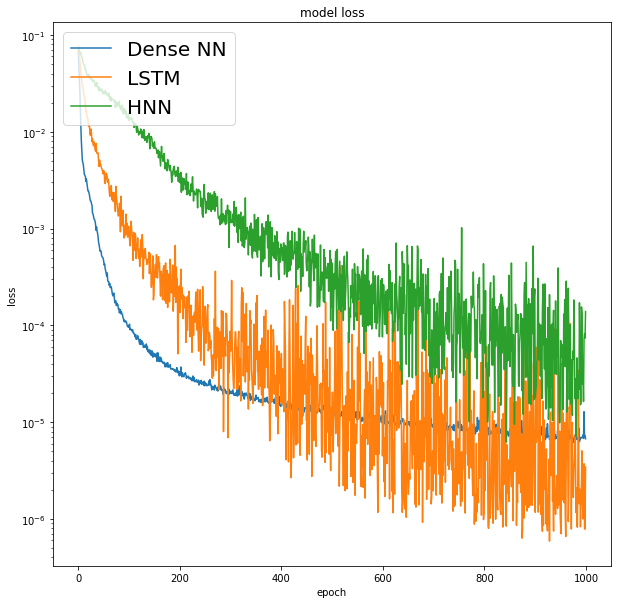

In [ ]:
#print(result.history.keys())

plt.rcParams['figure.figsize'] = [10, 10]

# summarize history for loss
plt.plot(result_1.history['loss'])
plt.plot(result_2.history['loss'])
plt.plot(result_3.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.legend(['Dense NN','LSTM','HNN'], loc='upper left')
plt.yscale("log")
plt.show()

## Plot trajectories generated to $t=512$ by Verlet integrators and neural network integrators


In [ ]:
# Final time
T_final = 512

n_step = int(T_final/dt_verlet)

# Initial conditions
x = np.zeros((1,2))
v = np.zeros((1,2))
x[0] = [-0.1,-0.2]
v[0] = [-0.2,-0.05]
verlet_HH.set_state(x,v)

# ==== Verlet integrator ====
t = 0.0
t_verlet_HH = np.zeros(n_step)
x_verlet_HH = np.zeros((n_step,2))
v_verlet_HH = np.zeros((n_step,2))
E_verlet_HH = np.zeros(n_step)



for k in range(n_step):
    t_verlet_HH[k] = t
    E_verlet_HH[k] = verlet_HH.energy()
    x_verlet_HH[k,:] = verlet_HH.x[:]
    v_verlet_HH[k,:] = verlet_HH.v[:]
    verlet_HH.integrate(1)
    t += dt_verlet



# ==== Verlet integrator 40dt_V====
t = 0.0

n_step_40 = int(T_final/dt)

t_verlet_dt = np.zeros(n_step_40)
x_verlet_dt = np.zeros((n_step_40,2))
v_verlet_dt = np.zeros((n_step_40,2))
E_verlet_dt = np.zeros(n_step_40)


verlet_dt.set_state(x,v)
for k in range(n_step_40):
    t_verlet_dt[k] = t
    E_verlet_dt[k] = verlet_dt.energy()
    x_verlet_dt[k,:] = verlet_dt.x[:]
    v_verlet_dt[k,:] = verlet_dt.v[:]
    verlet_dt.integrate(1)
    t += dt

        

# ==== Neural network integrators ====

# Initialise with Verlet integrator
x_initial_1 = np.zeros((nn_integrator_1.nsteps,nn_integrator_1.dynamical_system.dim))
v_initial_1 = np.zeros((nn_integrator_1.nsteps,nn_integrator_1.dynamical_system.dim))
x_initial_2 = np.zeros((nn_integrator_2.nsteps,nn_integrator_2.dynamical_system.dim))
v_initial_2 = np.zeros((nn_integrator_2.nsteps,nn_integrator_2.dynamical_system.dim))
x_initial_3 = np.zeros((nn_integrator_3.nsteps,nn_integrator_3.dynamical_system.dim))
v_initial_3 = np.zeros((nn_integrator_3.nsteps,nn_integrator_3.dynamical_system.dim))



verlet_HH.set_state(x,v)
for k in range(nn_integrator_1.nsteps):    
    x_initial_1[k,:] = verlet_HH.x[:]
    v_initial_1[k,:] = verlet_HH.v[:]
    verlet_HH.integrate(int(dt/dt_verlet))
verlet_HH.set_state(x,v)
for k in range(nn_integrator_2.nsteps):    
    x_initial_2[k,:] = verlet_HH.x[:]
    v_initial_2[k,:] = verlet_HH.v[:]
    verlet_HH.integrate(int(dt/dt_verlet))
verlet_HH.set_state(x,v)
for k in range(nn_integrator_3.nsteps):    
    x_initial_3[k,:] = verlet_HH.x[:]
    v_initial_3[k,:] = verlet_HH.v[:]
    verlet_HH.integrate(int(dt/dt_verlet))



nn_integrator_1.set_state(x_initial_1,v_initial_1)
t_1 = (nn_integrator_1.nsteps-1)*nn_integrator_1.dt
nn_integrator_2.set_state(x_initial_2,v_initial_2)
t_2 = (nn_integrator_2.nsteps-1)*nn_integrator_2.dt
nn_integrator_3.set_state(x_initial_3,v_initial_3)
t_3 = (nn_integrator_3.nsteps-1)*nn_integrator_3.dt




# Timestepping loop
t_nn_1 = []
x_nn_1 = []
v_nn_1 = []
E_nn_1 = []
t_nn_2 = []
x_nn_2 = []
v_nn_2 = []
E_nn_2 = []
t_nn_3 = []
x_nn_3 = []
v_nn_3 = []
E_nn_3 = []



while t_1<T_final:
    t_nn_1.append(t_1)
    x_nn_1.append(nn_integrator_1.x)
    v_nn_1.append(nn_integrator_1.v)
    E_nn_1.append(nn_integrator_1.energy())
    nn_integrator_1.integrate(1)
    t_1 += dt
while t_2<T_final:
    t_nn_2.append(t_2)
    x_nn_2.append(nn_integrator_2.x)
    v_nn_2.append(nn_integrator_2.v)
    E_nn_2.append(nn_integrator_2.energy())
    nn_integrator_2.integrate(1)
    t_2 += dt
while t_3<T_final:
    t_nn_3.append(t_3)
    x_nn_3.append(nn_integrator_3.x)
    v_nn_3.append(nn_integrator_3.v)
    E_nn_3.append(nn_integrator_3.energy())
    nn_integrator_3.integrate(1)
    t_3 += dt

 



x_nn_1 = np.array(x_nn_1)
x_nn_2 = np.array(x_nn_2)
x_nn_3 = np.array(x_nn_3)
x_verlet_HH = np.array(x_verlet_HH)
x_verlet_dt = np.array(x_verlet_dt)
v_nn_1 = np.array(v_nn_1)
v_nn_2 = np.array(v_nn_2)
v_nn_3 = np.array(v_nn_3)
v_verlet_HH = np.array(v_verlet_HH)
v_verlet_dt = np.array(v_verlet_dt)



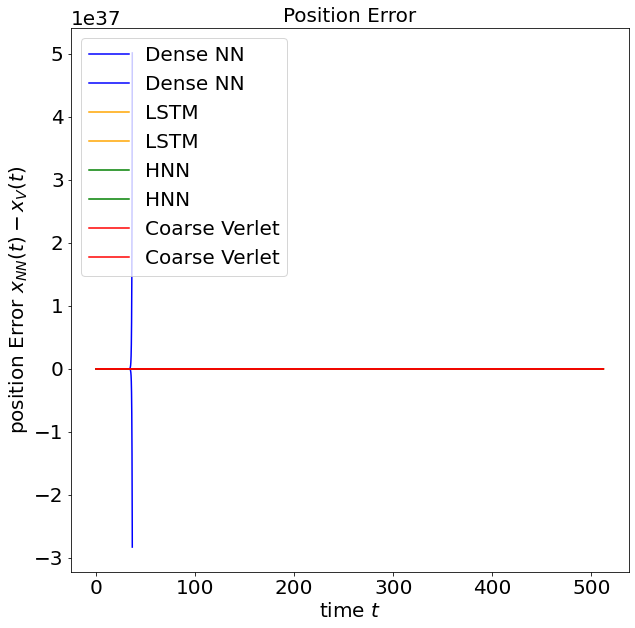

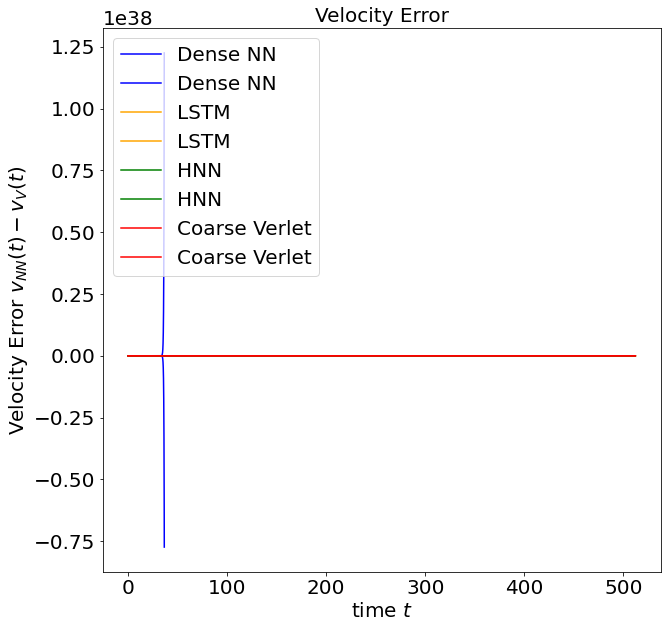

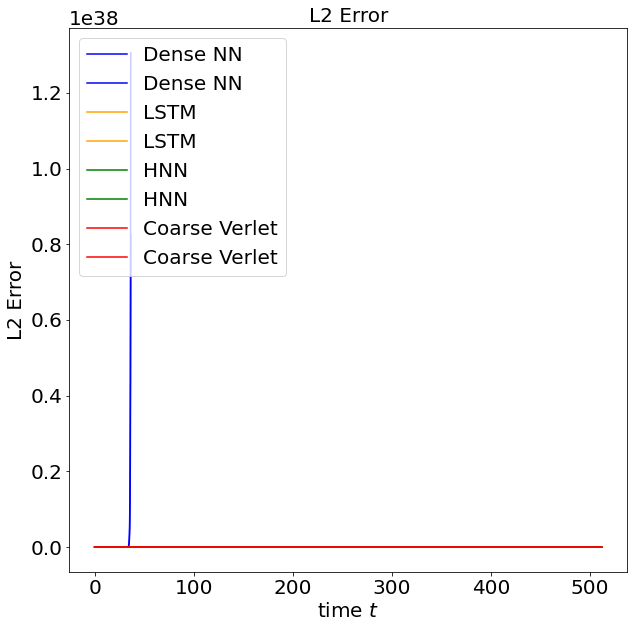

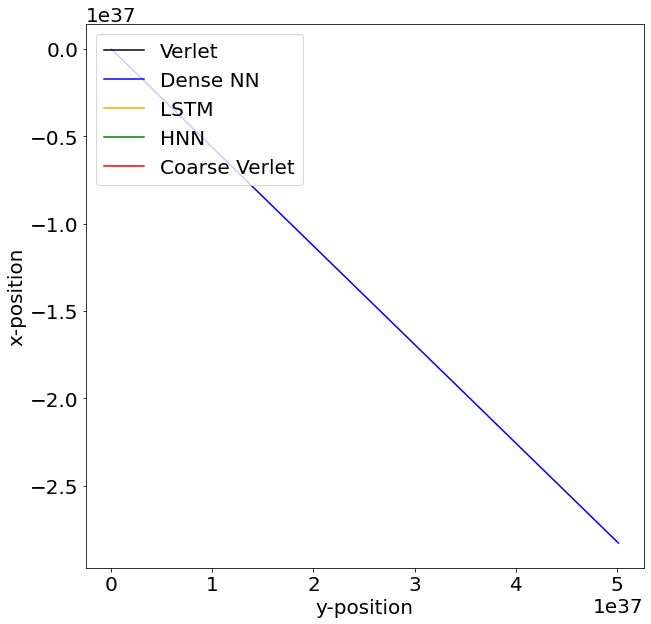

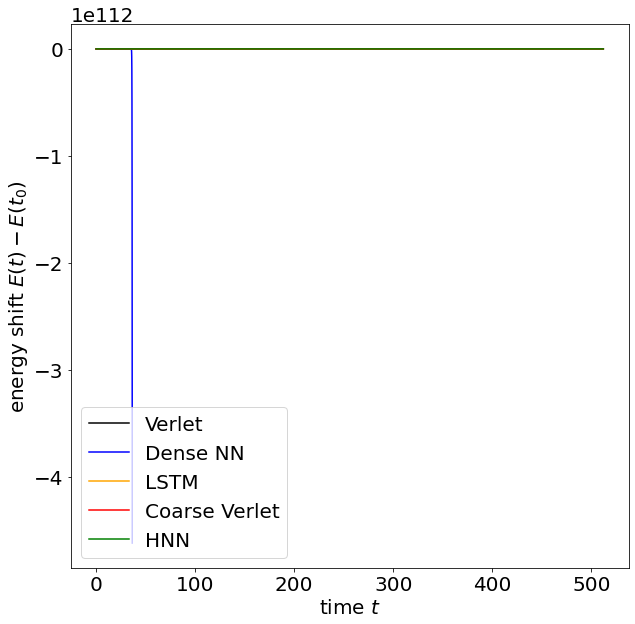

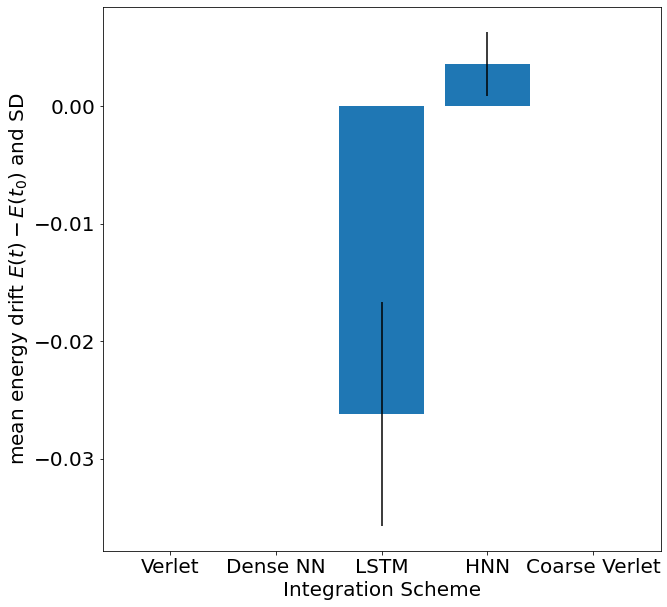

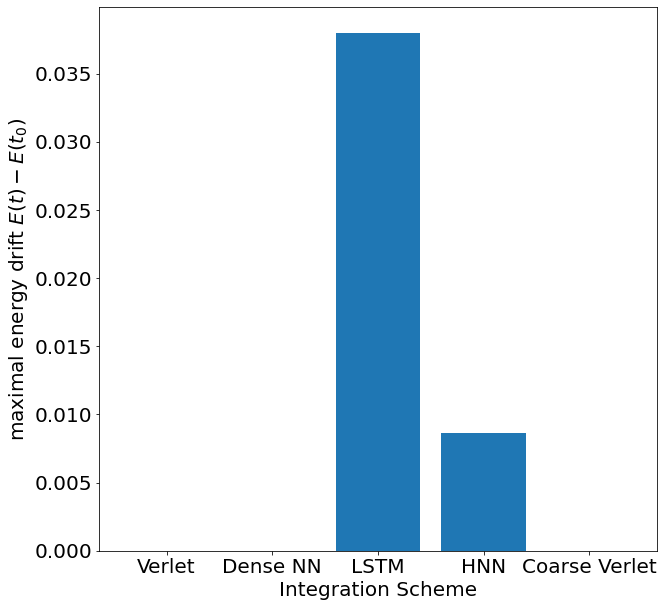

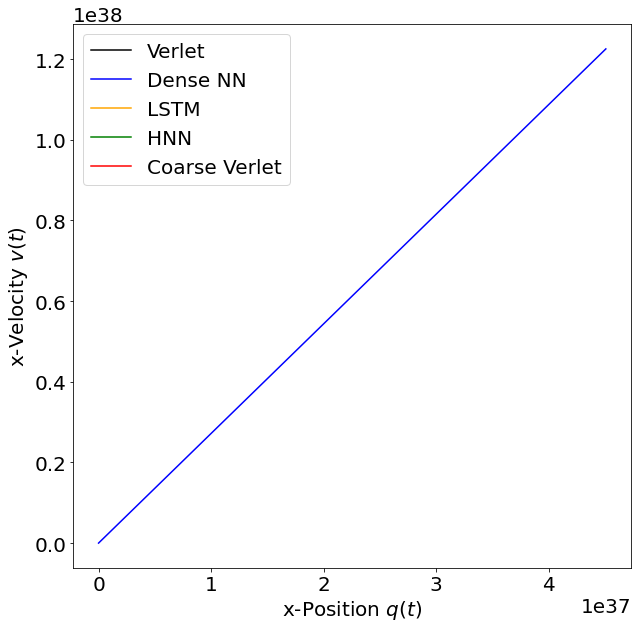

In [ ]:
# Plot position error as a function of time
plt.clf()
plt.rcParams['figure.figsize'] = [10, 10]

plt.plot(t_nn_1,x_nn_1-x_verlet_HH[int((nsteps_1-1)*dt/dt_verlet)::int(dt/dt_verlet)],label='Dense NN',color='blue')
plt.plot(t_nn_2,x_nn_2-x_verlet_HH[int((nsteps_2-1)*dt/dt_verlet)::int(dt/dt_verlet)],label='LSTM',color='orange')
plt.plot(t_nn_3,x_nn_3-x_verlet_HH[::int(dt/dt_verlet)],label='HNN',color='green')
plt.plot(t_verlet_dt,x_verlet_dt-x_verlet_HH[::int(dt/dt_verlet)],label='Coarse Verlet',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('position Error $x_{NN}(t)-x_V(t)$')
ax.set_title('Position Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()

# Plot velocity error as a function of time

plt.plot(t_nn_1,v_nn_1-v_verlet_HH[int((nsteps_1-1)*dt/dt_verlet)::int(dt/dt_verlet)],label='Dense NN',color='blue')
plt.plot(t_nn_2,v_nn_2-v_verlet_HH[int((nsteps_2-1)*dt/dt_verlet)::int(dt/dt_verlet)],label='LSTM',color='orange')
plt.plot(t_nn_3,v_nn_3-v_verlet_HH[::int(dt/dt_verlet)],label='HNN',color='green')
plt.plot(t_verlet_dt,v_verlet_dt-v_verlet_HH[::int(dt/dt_verlet)],label='Coarse Verlet',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('Velocity Error $v_{NN}(t)-v_V(t)$')
ax.set_title('Velocity Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()

# Plot L2 error as a function of time

plt.plot(t_nn_1,((v_nn_1-v_verlet_HH[int((nsteps_1-1)*dt/dt_verlet)::int(dt/dt_verlet)])**2+(x_nn_1-x_verlet_HH[int((nsteps_1-1)*dt/dt_verlet)::int(dt/dt_verlet)])**2)**0.5,label='Dense NN',color='blue')
plt.plot(t_nn_2,((v_nn_2-v_verlet_HH[int((nsteps_2-1)*dt/dt_verlet)::int(dt/dt_verlet)])**2+(x_nn_2-x_verlet_HH[int((nsteps_2-1)*dt/dt_verlet)::int(dt/dt_verlet)])**2)**0.5,label='LSTM',color='orange')
plt.plot(t_nn_3,((v_nn_3-v_verlet_HH[::int(dt/dt_verlet)])**2+(x_nn_3-x_verlet_HH[::int(dt/dt_verlet)])**2)**0.5,label='HNN',color='green')
plt.plot(t_verlet_dt,((v_verlet_dt-v_verlet_HH[::int(dt/dt_verlet)])**2+(x_verlet_dt-x_verlet_HH[::int(dt/dt_verlet)])**2)**0.5,label='Coarse Verlet',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('L2 Error')
ax.set_title('L2 Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()

#subplots of x- and y- position for all 4

plt.rcParams['figure.figsize'] = [10, 10]

plt.clf()
plt.plot(x_verlet_HH[:,0],x_verlet_HH[:,1],label='Verlet',color='black')
plt.plot(x_nn_1[:,0],x_nn_1[:,1],label='Dense NN',color='blue')
plt.plot(x_nn_2[:,0],x_nn_2[:,1],label='LSTM',color='orange')
plt.plot(x_nn_3[:,0],x_nn_3[:,1],label='HNN',color='green')
plt.plot(x_verlet_dt[:,0],x_verlet_dt[:,1],label='Coarse Verlet',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylabel('x-position')
ax.set_xlabel('y-position')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.show()

plt.clf()
# Plot energy drift as a function of time
# (subtract energy at time t=0 to show energy drift)

plt.plot(t_verlet_HH,E_verlet_HH-E_verlet_HH[0],label='Verlet',color='black')
plt.plot(t_nn_1,E_nn_1-E_nn_1[0],label='Dense NN',color='blue')
plt.plot(t_nn_2,E_nn_2-E_nn_2[0],label='LSTM',color='orange')
plt.plot(t_verlet_dt,E_verlet_dt-E_verlet_dt[0],label='Coarse Verlet',color='red')
plt.plot(t_nn_3,E_nn_3-E_nn_3[0],label='HNN',color='green')
plt.legend(loc='lower left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('energy shift $E(t)-E(t_0)$')
#ax.grid()
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

plt.show()


# Plot average energy drift and standard deviation for each integrator.

tags = np.array(['Verlet','Dense NN','LSTM','HNN','Coarse Verlet'])
maxima = np.array([np.amax(np.abs(E_verlet_HH-E_verlet_HH[0])),np.amax(np.abs(E_nn_1-E_nn_1[0])),np.amax(np.abs(E_nn_2-E_nn_2[0])),np.amax(np.abs(E_nn_3-E_nn_3[0])),np.amax(np.abs(E_verlet_dt-E_verlet_dt[0]))])
means = np.array([np.mean(E_verlet_HH-E_verlet_HH[0]),np.mean(E_nn_1-E_nn_1[0]),np.mean(E_nn_2-E_nn_2[0]),np.mean(E_nn_3-E_nn_3[0]),np.mean(E_verlet_dt-E_verlet_dt[0])])
std = np.array([np.std(E_verlet_HH-E_verlet_HH[0]),np.std(E_nn_1-E_nn_1[0]),np.std(E_nn_2-E_nn_2[0]),np.std(E_nn_3-E_nn_3[0]),np.std(E_verlet_dt-E_verlet_dt[0])])
tagsticks = np.array([0,1,2,3,4])

#plt.bar(tags,maxima)
plt.bar(tags,means,yerr=std)
ax = plt.gca()
ax.set_xlabel('Integration Scheme')
ax.set_ylabel('mean energy drift $E(t)-E(t_0)$ and SD')
plt.xticks(tagsticks,tags)

#ax.grid()
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

plt.show()

plt.clf()
plt.bar(tags,maxima)
ax = plt.gca()
ax.set_xlabel('Integration Scheme')
ax.set_ylabel('maximal energy drift $E(t)-E(t_0)$')
plt.xticks(tagsticks,tags)
plt.show()

#subplots of x-position versus x-velocity for all 4

plt.rcParams['figure.figsize'] = [10, 10]

plt.clf()
plt.plot(x_verlet_HH[:,0],v_verlet_HH[:,0],label='Verlet',color='black')
plt.plot(x_nn_1[:,0],v_nn_1[:,0],label='Dense NN',color='blue')
plt.plot(x_nn_2[:,0],v_nn_2[:,0],label='LSTM',color='orange')
plt.plot(x_nn_3[:,0],v_nn_3[:,0],label='HNN',color='green')
plt.plot(x_verlet_dt[:,0],v_verlet_dt[:,0],label='Coarse Verlet',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylabel('x-Velocity $v(t)$')
ax.set_xlabel('x-Position $q(t)$')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.show()

## Plot trajectories of all integrators except dense NN


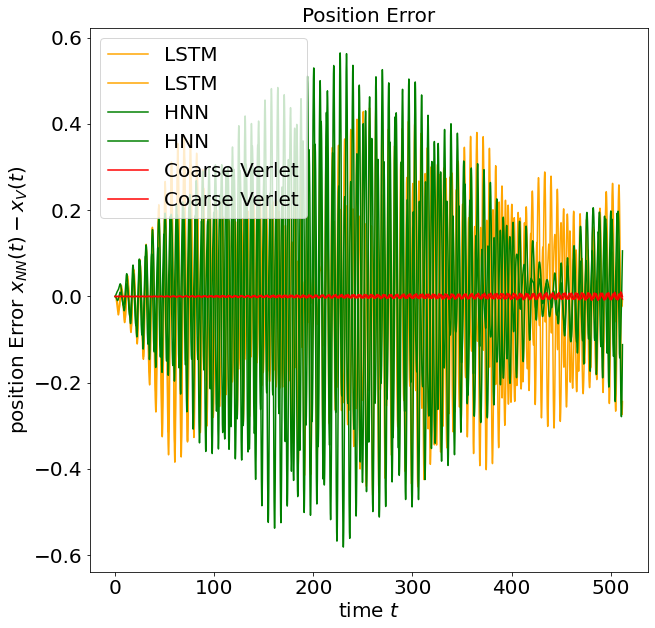

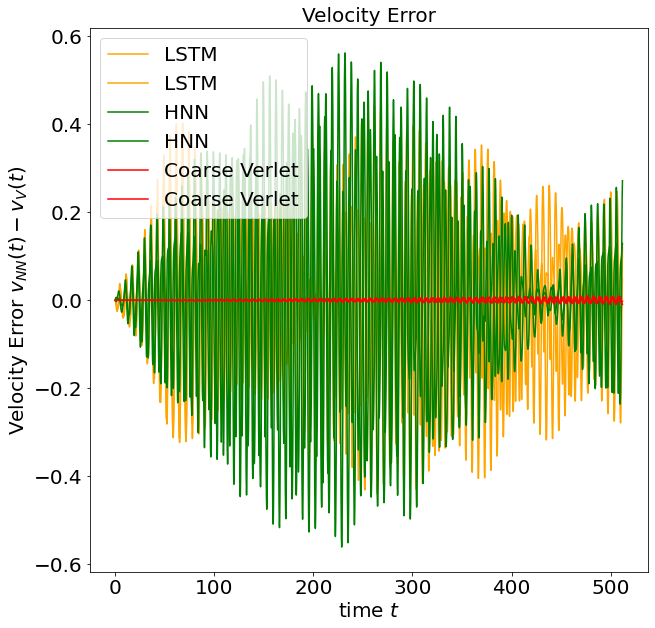

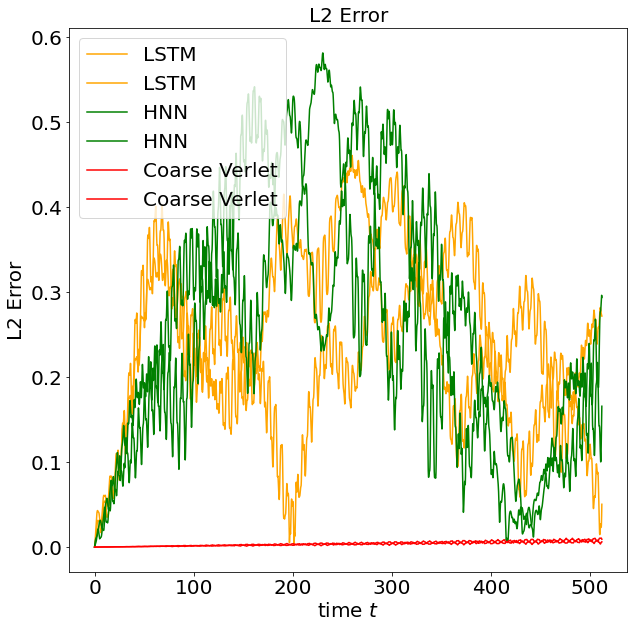

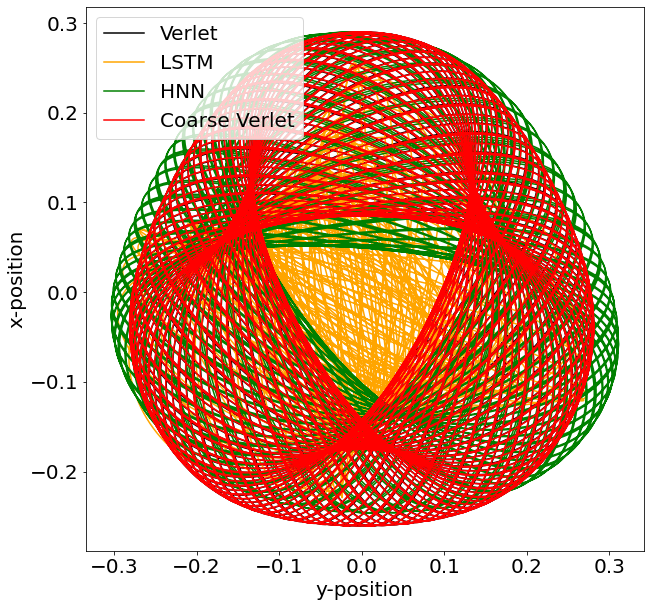

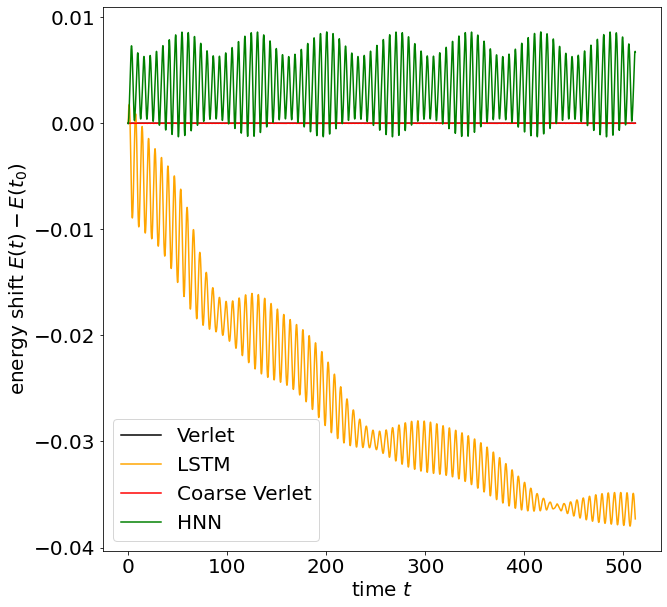

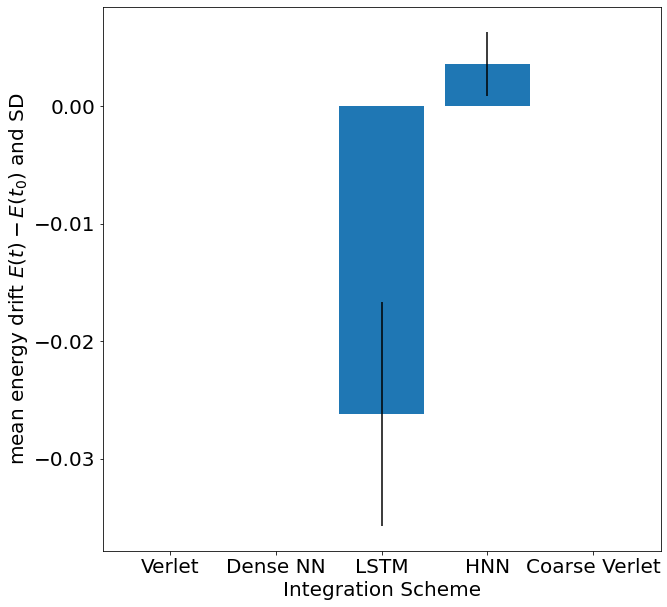

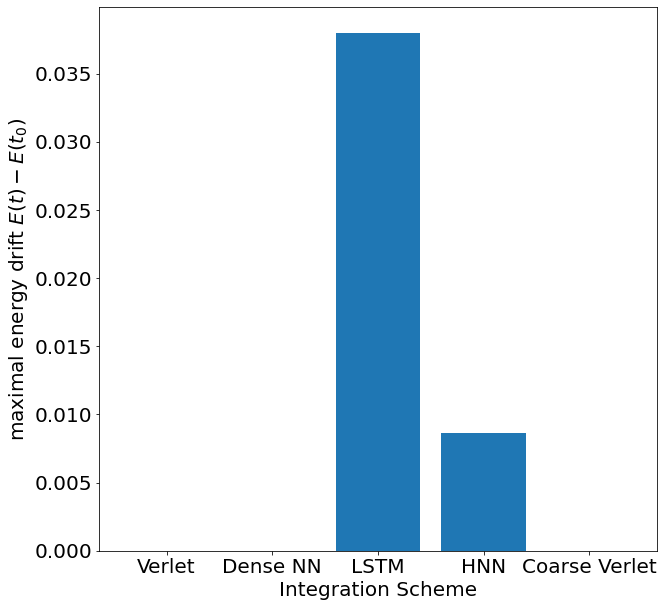

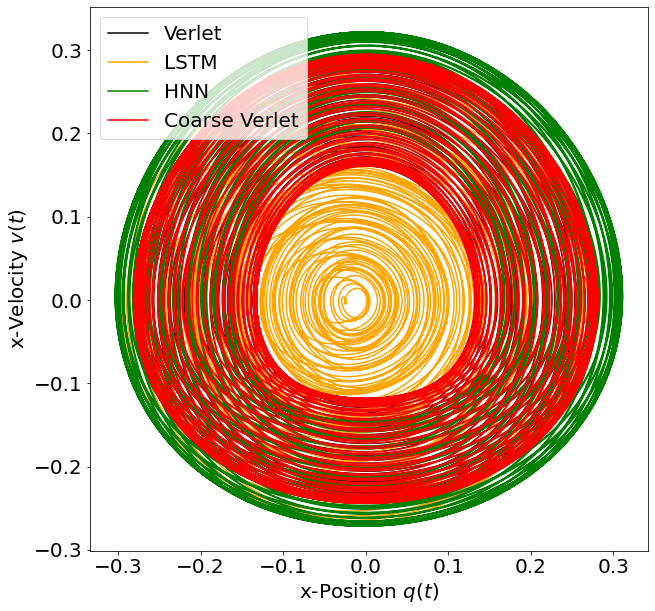

In [ ]:
# Plot position error as a function of time
plt.clf()
plt.rcParams['figure.figsize'] = [10, 10]

#plt.plot(t_nn_1,x_nn_1-x_verlet_HH[int((nsteps_1-1)*dt/dt_verlet)::int(dt/dt_verlet)],label='Dense NN',color='blue')
plt.plot(t_nn_2,x_nn_2-x_verlet_HH[int((nsteps_2-1)*dt/dt_verlet)::int(dt/dt_verlet)],label='LSTM',color='orange')
plt.plot(t_nn_3,x_nn_3-x_verlet_HH[::int(dt/dt_verlet)],label='HNN',color='green')
plt.plot(t_verlet_dt,x_verlet_dt-x_verlet_HH[::int(dt/dt_verlet)],label='Coarse Verlet',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('position Error $x_{NN}(t)-x_V(t)$')
ax.set_title('Position Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()

# Plot velocity error as a function of time

#plt.plot(t_nn_1,v_nn_1-v_verlet_HH[int((nsteps_1-1)*dt/dt_verlet)::int(dt/dt_verlet)],label='Dense NN',color='blue')
plt.plot(t_nn_2,v_nn_2-v_verlet_HH[int((nsteps_2-1)*dt/dt_verlet)::int(dt/dt_verlet)],label='LSTM',color='orange')
plt.plot(t_nn_3,v_nn_3-v_verlet_HH[::int(dt/dt_verlet)],label='HNN',color='green')
plt.plot(t_verlet_dt,v_verlet_dt-v_verlet_HH[::int(dt/dt_verlet)],label='Coarse Verlet',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('Velocity Error $v_{NN}(t)-v_V(t)$')
ax.set_title('Velocity Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()

# Plot L2 error as a function of time

#plt.plot(t_nn_1,((v_nn_1-v_verlet_HH[int((nsteps_1-1)*dt/dt_verlet)::int(dt/dt_verlet)])**2+(x_nn_1-x_verlet_HH[int((nsteps_1-1)*dt/dt_verlet)::int(dt/dt_verlet)])**2)**0.5,label='Dense NN',color='blue')
plt.plot(t_nn_2,((v_nn_2-v_verlet_HH[int((nsteps_2-1)*dt/dt_verlet)::int(dt/dt_verlet)])**2+(x_nn_2-x_verlet_HH[int((nsteps_2-1)*dt/dt_verlet)::int(dt/dt_verlet)])**2)**0.5,label='LSTM',color='orange')
plt.plot(t_nn_3,((v_nn_3-v_verlet_HH[::int(dt/dt_verlet)])**2+(x_nn_3-x_verlet_HH[::int(dt/dt_verlet)])**2)**0.5,label='HNN',color='green')
plt.plot(t_verlet_dt,((v_verlet_dt-v_verlet_HH[::int(dt/dt_verlet)])**2+(x_verlet_dt-x_verlet_HH[::int(dt/dt_verlet)])**2)**0.5,label='Coarse Verlet',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('L2 Error')
ax.set_title('L2 Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()

#subplots of x- and y- position for all 4

plt.rcParams['figure.figsize'] = [10, 10]

plt.clf()
plt.plot(x_verlet_HH[:,0],x_verlet_HH[:,1],label='Verlet',color='black')
#plt.plot(x_nn_1[:,0],x_nn_1[:,1],label='Dense NN',color='blue')
plt.plot(x_nn_2[:,0],x_nn_2[:,1],label='LSTM',color='orange')
plt.plot(x_nn_3[:,0],x_nn_3[:,1],label='HNN',color='green')
plt.plot(x_verlet_dt[:,0],x_verlet_dt[:,1],label='Coarse Verlet',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylabel('x-position')
ax.set_xlabel('y-position')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.show()

plt.clf()
# Plot energy drift as a function of time
# (subtract energy at time t=0 to show energy drift)

plt.plot(t_verlet_HH,E_verlet_HH-E_verlet_HH[0],label='Verlet',color='black')
#plt.plot(t_nn_1,E_nn_1-E_nn_1[0],label='Dense NN',color='blue')
plt.plot(t_nn_2,E_nn_2-E_nn_2[0],label='LSTM',color='orange')
plt.plot(t_verlet_dt,E_verlet_dt-E_verlet_dt[0],label='Coarse Verlet',color='red')
plt.plot(t_nn_3,E_nn_3-E_nn_3[0],label='HNN',color='green')
plt.legend(loc='lower left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('energy shift $E(t)-E(t_0)$')
#ax.grid()
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

plt.show()


# Plot average energy drift and standard deviation for each integrator.

tags = np.array(['Verlet','Dense NN','LSTM','HNN','Coarse Verlet'])
maxima = np.array([np.amax(np.abs(E_verlet_HH-E_verlet_HH[0])),np.amax(np.abs(E_nn_1-E_nn_1[0])),np.amax(np.abs(E_nn_2-E_nn_2[0])),np.amax(np.abs(E_nn_3-E_nn_3[0])),np.amax(np.abs(E_verlet_dt-E_verlet_dt[0]))])
means = np.array([np.mean(E_verlet_HH-E_verlet_HH[0]),np.mean(E_nn_1-E_nn_1[0]),np.mean(E_nn_2-E_nn_2[0]),np.mean(E_nn_3-E_nn_3[0]),np.mean(E_verlet_dt-E_verlet_dt[0])])
std = np.array([np.std(E_verlet_HH-E_verlet_HH[0]),np.std(E_nn_1-E_nn_1[0]),np.std(E_nn_2-E_nn_2[0]),np.std(E_nn_3-E_nn_3[0]),np.std(E_verlet_dt-E_verlet_dt[0])])
tagsticks = np.array([0,1,2,3,4])

#plt.bar(tags,maxima)
plt.bar(tags,means,yerr=std)
ax = plt.gca()
ax.set_xlabel('Integration Scheme')
ax.set_ylabel('mean energy drift $E(t)-E(t_0)$ and SD')
plt.xticks(tagsticks,tags)
ax.set_xticklabels(means)

#ax.grid()
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

plt.show()

plt.clf()
plt.bar(tags,maxima)
ax = plt.gca()
ax.set_xlabel('Integration Scheme')
ax.set_ylabel('maximal energy drift $E(t)-E(t_0)$')
plt.xticks(tagsticks,tags)
plt.show()

#subplots of x-position versus x-velocity for all 4

plt.rcParams['figure.figsize'] = [10, 10]

plt.clf()
plt.plot(x_verlet_HH[:,0],v_verlet_HH[:,0],label='Verlet',color='black')
#plt.plot(x_nn_1[:,0],v_nn_1[:,0],label='Dense NN',color='blue')
plt.plot(x_nn_2[:,0],v_nn_2[:,0],label='LSTM',color='orange')
plt.plot(x_nn_3[:,0],v_nn_3[:,0],label='HNN',color='green')
plt.plot(x_verlet_dt[:,0],v_verlet_dt[:,0],label='Coarse Verlet',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylabel('x-Velocity $v(t)$')
ax.set_xlabel('x-Position $q(t)$')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.show()

## Plot trajectories of only baseline integrator and HNN


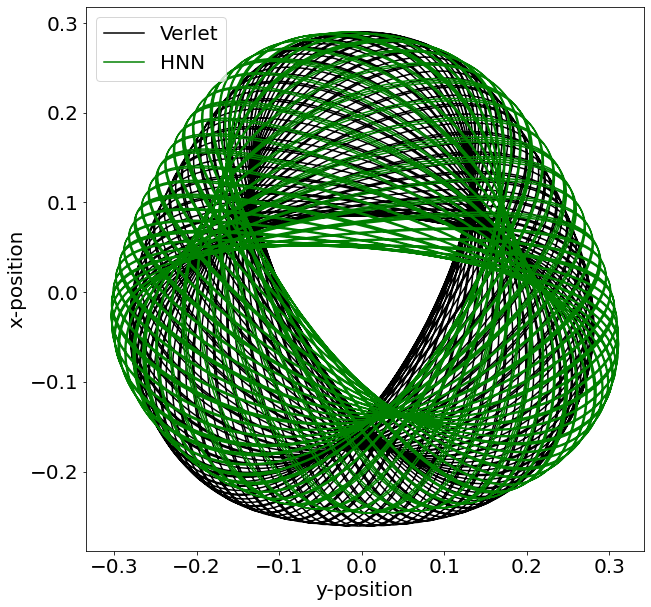

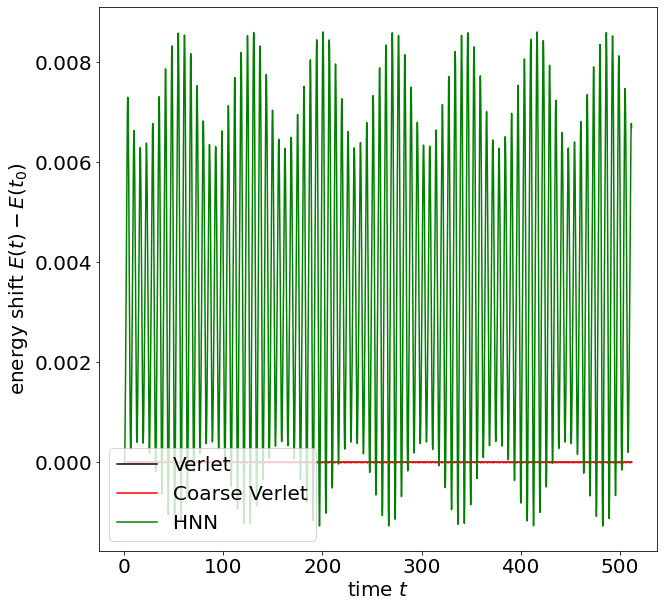

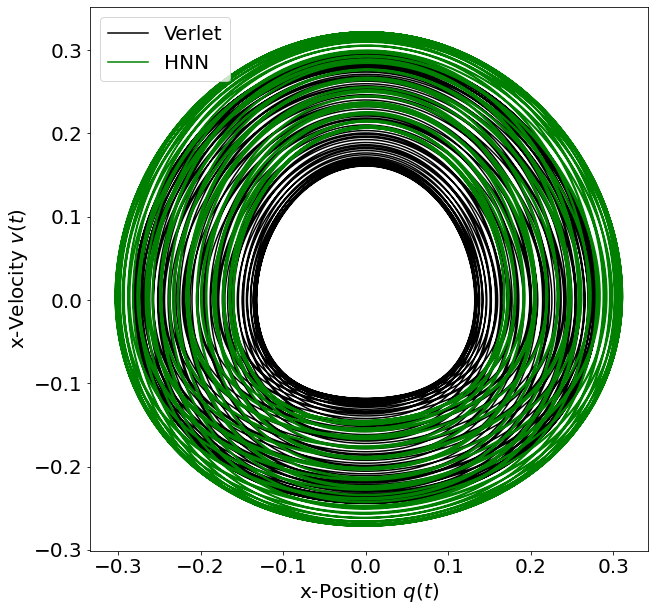

In [ ]:


#subplots of x- and y- position for all 4

plt.rcParams['figure.figsize'] = [10, 10]

plt.clf()
plt.plot(x_verlet_HH[:,0],x_verlet_HH[:,1],label='Verlet',color='black')
#plt.plot(x_nn_1[:,0],x_nn_1[:,1],label='Dense NN',color='blue')
#plt.plot(x_nn_2[:,0],x_nn_2[:,1],label='LSTM',color='orange')
plt.plot(x_nn_3[:,0],x_nn_3[:,1],label='HNN',color='green')
#plt.plot(x_verlet_dt[:,0],x_verlet_dt[:,1],label='Coarse Verlet',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylabel('x-position')
ax.set_xlabel('y-position')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.show()

plt.clf()
# Plot energy drift as a function of time
# (subtract energy at time t=0 to show energy drift)

plt.plot(t_verlet_HH,E_verlet_HH-E_verlet_HH[0],label='Verlet',color='black')
#plt.plot(t_nn_1,E_nn_1-E_nn_1[0],label='Dense NN',color='blue')
#plt.plot(t_nn_2,E_nn_2-E_nn_2[0],label='LSTM',color='orange')
plt.plot(t_verlet_dt,E_verlet_dt-E_verlet_dt[0],label='Coarse Verlet',color='red')
plt.plot(t_nn_3,E_nn_3-E_nn_3[0],label='HNN',color='green')
plt.legend(loc='lower left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('energy shift $E(t)-E(t_0)$')
#ax.grid()
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

plt.show()




#subplots of x-position versus x-velocity for all 4

plt.rcParams['figure.figsize'] = [10, 10]

plt.clf()
plt.plot(x_verlet_HH[:,0],v_verlet_HH[:,0],label='Verlet',color='black')
#plt.plot(x_nn_1[:,0],v_nn_1[:,0],label='Dense NN',color='blue')
#plt.plot(x_nn_2[:,0],v_nn_2[:,0],label='LSTM',color='orange')
plt.plot(x_nn_3[:,0],v_nn_3[:,0],label='HNN',color='green')
#plt.plot(x_verlet_dt[:,0],v_verlet_dt[:,0],label='Coarse Verlet',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylabel('x-Velocity $v(t)$')
ax.set_xlabel('x-Position $q(t)$')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.show()

## Plot trajectories of only baseline integrator and LSTM


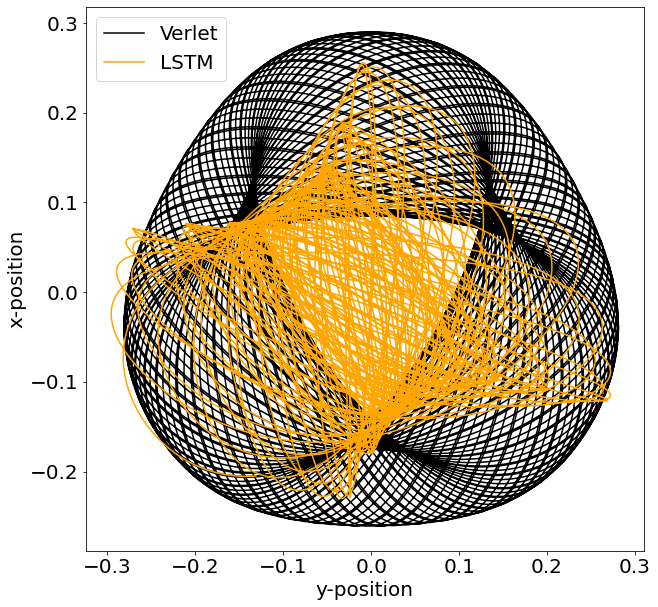

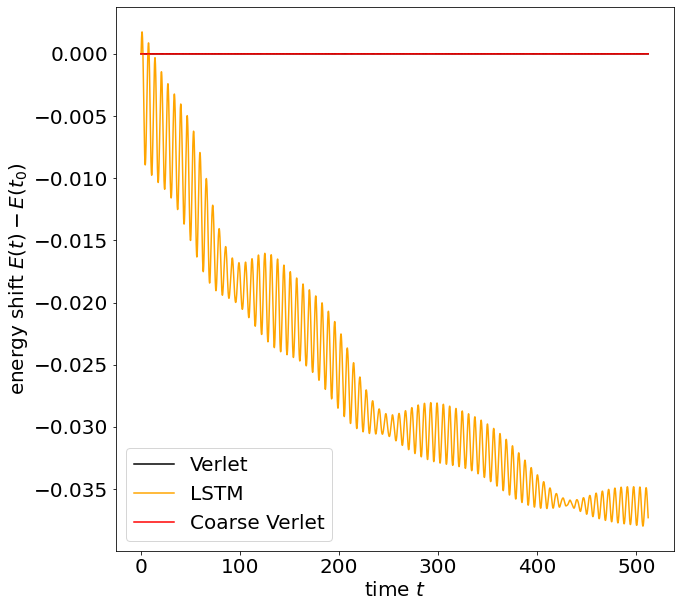

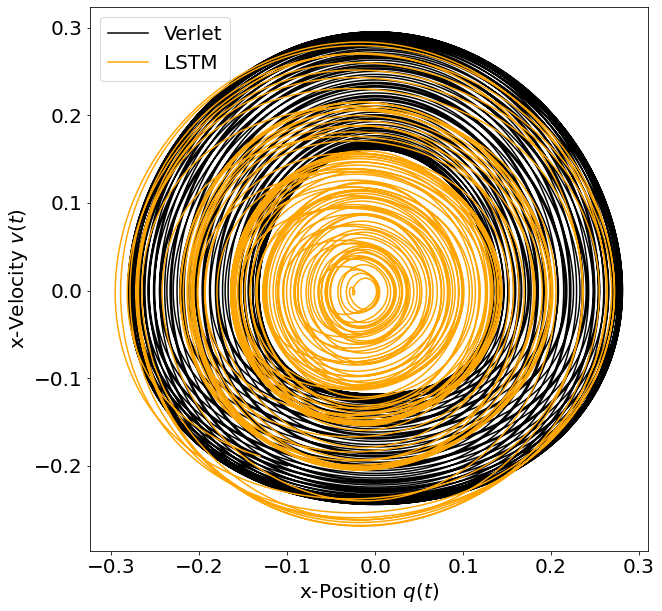

In [ ]:


#subplots of x- and y- position for all 4

plt.rcParams['figure.figsize'] = [10, 10]

plt.clf()
plt.plot(x_verlet_HH[:,0],x_verlet_HH[:,1],label='Verlet',color='black')
#plt.plot(x_nn_1[:,0],x_nn_1[:,1],label='Dense NN',color='blue')
plt.plot(x_nn_2[:,0],x_nn_2[:,1],label='LSTM',color='orange')
#plt.plot(x_nn_3[:,0],x_nn_3[:,1],label='HNN',color='green')
#plt.plot(x_verlet_dt[:,0],x_verlet_dt[:,1],label='Coarse Verlet',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylabel('x-position')
ax.set_xlabel('y-position')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.show()

plt.clf()
# Plot energy drift as a function of time
# (subtract energy at time t=0 to show energy drift)

plt.plot(t_verlet_HH,E_verlet_HH-E_verlet_HH[0],label='Verlet',color='black')
#plt.plot(t_nn_1,E_nn_1-E_nn_1[0],label='Dense NN',color='blue')
plt.plot(t_nn_2,E_nn_2-E_nn_2[0],label='LSTM',color='orange')
plt.plot(t_verlet_dt,E_verlet_dt-E_verlet_dt[0],label='Coarse Verlet',color='red')
#plt.plot(t_nn_3,E_nn_3-E_nn_3[0],label='HNN',color='green')
plt.legend(loc='lower left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('energy shift $E(t)-E(t_0)$')
#ax.grid()
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

plt.show()


#subplots of x-position versus x-velocity for all 4

plt.rcParams['figure.figsize'] = [10, 10]

plt.clf()
plt.plot(x_verlet_HH[:,0],v_verlet_HH[:,0],label='Verlet',color='black')
#plt.plot(x_nn_1[:,0],v_nn_1[:,0],label='Dense NN',color='blue')
plt.plot(x_nn_2[:,0],v_nn_2[:,0],label='LSTM',color='orange')
#plt.plot(x_nn_3[:,0],v_nn_3[:,0],label='HNN',color='green')
#plt.plot(x_verlet_dt[:,0],v_verlet_dt[:,0],label='Coarse Verlet',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylabel('x-Velocity $v(t)$')
ax.set_xlabel('x-Position $q(t)$')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.show()